## 0116 Henon写像に　Kalman Neuro Computing を適用する

#### なぜ Henon か？

### NN は $\vec{y^O}_t = \mathcal{M}(\vec{y^O}_{t-1})$ ではなく $\vec{y^O}_t = \mathcal{M}(\vec{y^O}_{t-1})$ のモデルのパラメータ推定
  - モデルの形を $f(t)$ ではなく漸化式的なモデルに合わせたい
  - → Kalman Neuro Computing は Simultaneous estimation ではない！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Numpy {np.__version__}")
print()

Numpy 1.23.2



# Henon 写像

RNN に食べさせるための多変数時系列データですが、カオスに時間発展してくれた方が予測しづらくていい実験材料になるでしょう。ここでは、Henon 写像

$$
\left\lbrace\begin{array}{l}
x_{i+1} = 1- ax_{i}^2 + y_{i} \cr
y_{i+1} = bx_{i}
\end{array}\right.
$$

を使用します。これは有名なローレンツ方程式の本質的性質を持ちつつ、より簡単な式で表せることを目的に考案されたモデルです。

Henon 写像によって時間発展するベクトル列 $\vec{Y}_t = (x_t, y_t)^T$ を RNN で学習させてみましょう。

In [2]:
# Henon写像のデータを生成する関数
# 引数a,bがHenon写像のパラメータ,引数nは生成したいデータ数(時系列長)
def Henon(Yt: np.ndarray, a: float =1.4, b: float =0.3) -> np.ndarray:
    xt, yt = Yt
    nx = 1 - a * xt * xt + yt
    ny = b * xt
    return np.array([nx, ny])

In [3]:
def Henon_explicit(X: np.ndarray, t: float) -> np.ndarray:
    x, y, a, b = X
    nx, ny = Henon([x, y], a, b)
    return np.array([nx, ny, a, b])

In [4]:
def plot_trajectory(Y: np.ndarray, ts: int, te: int, marker: str, label: str, ax: plt.Axes) -> None:
    ax[0, 0].plot(Y[:, 0], Y[:, 1], marker, label=label)
    ax[0, 0].set_xlabel('$x_t$')
    ax[0, 0].set_ylabel('$y_t$')
    ax[0, 0].legend(loc="lower right")

    ax[0, 1].plot(np.arange(ts, te), Y[:, 1], marker, label=label)
    ax[0, 1].set_xlabel('$t$')
    ax[0, 1].set_ylabel('$y_t$')

    ax[1, 0].plot(Y[:, 0], np.arange(ts, te), marker, label=label)
    ax[1, 0].set_ylabel('$t$')
    ax[1, 0].set_xlabel('$x_t$')

## 訓練データ・検証データ

初期値 $\vec{Y}_0 = (1.1, 0.2)^T$ として 60 時点のデータを作成し、

- 訓練データ長: 前 40 点 で学習
- 検証データ長: 後 20 点 を予測

として RNN の性能を評価してみます。

In [5]:
# Create Time Series Sample

train_size = 40
test_size  = 20

true_Y = np.zeros((train_size + test_size, 2))
train_Y, test_Y = np.zeros((train_size, 2)), np.zeros((test_size, 2))

z = np.array([1.1, 0.2])

for t in range(train_size):
    true_Y[t] = z
    train_Y[t] = z + np.random.randn(2) * 0.1
    z = Henon(z)

for t in range(test_size):
    true_Y[train_size + t] = z
    test_Y[t] = z + np.random.randn(2) * 0.1
    z = Henon(z)

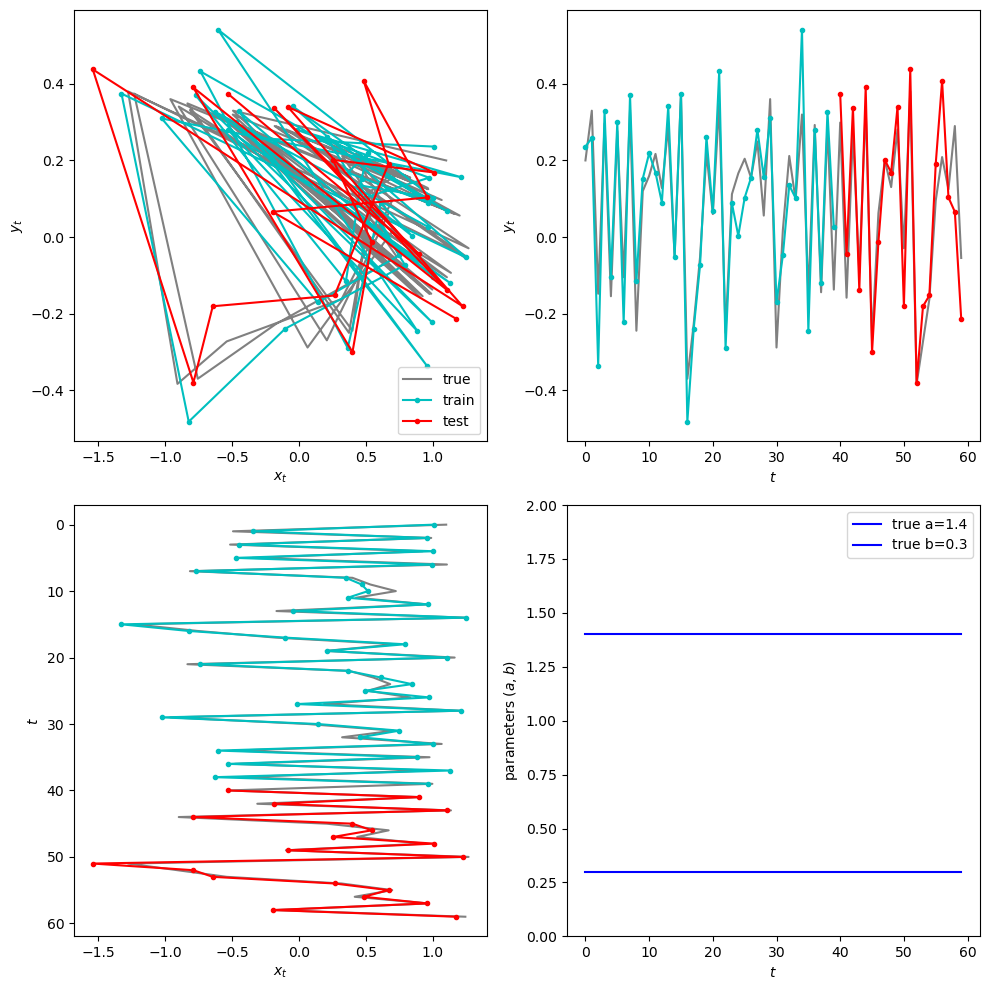

In [6]:
# Plot Time Series Sample

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_trajectory(true_Y,  0,          train_size+test_size, "gray", 'true', ax)
plot_trajectory(train_Y, 0,          train_size,           "c.-", 'train', ax)
plot_trajectory(test_Y,  train_size, train_size+test_size, "r.-", 'test',  ax)

ax[1, 0].invert_yaxis()

ax[1, 1].plot(np.ones(train_size+test_size)*1.4, 'blue',  label='true a=1.4')
ax[1, 1].plot(np.ones(train_size+test_size)*0.3, 'blue',  label='true b=0.3')
ax[1, 1].set_ylim(0, 2)
ax[1, 1].set_xlabel('$t$')
ax[1, 1].set_ylabel('parameters $(a, b)$')
ax[1, 1].legend()

plt.tight_layout()

plt.savefig('1_input.png')
plt.show()

# Kalman Filter によるデータ同化

In [7]:
def get_tlm_by_approx(X: np.ndarray, t: float, Model, delta: float=0.001):
    J = X.shape[0]
    M = np.zeros((J, J))
    for j in range(J):
        ej = np.zeros(J)
        ej[j] = 1

        M_col_j = (Model(X + delta * ej, t) - Model(X, t)) / delta

        M[:, j] = M_col_j

    return M

In [8]:
M = get_tlm_by_approx(np.array([1.1, 0.2, 1.4, 0.3]), 0, Henon_explicit)
print(f"M: \n {M}")

M: 
 [[-3.0814  1.     -1.21    0.    ]
 [ 0.3     0.      0.      1.1   ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [9]:
def KalmanFilter(X: np.ndarray, t: float, y: np.ndarray, Model, M, H, R, Pa, Q=0):
    # forecast
    X = Model(X, t)
    Pf = M @ Pa @ M.T + Q

    # update
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    nX = X + K @ (y - H @ X)
    nPa = (np.eye(X.shape[0]) - K @ H) @ Pf

    return Pf, nX, nPa

In [10]:
def plot_result_trajectory(assim_X, assim_Pa):
    assim_X = np.array(assim_X[1:])
    assim_Pa = np.array(assim_Pa[1:])

    forecast_X = np.zeros((test_size+1, 4))
    forecast_X[0, :] = assim_X[-1, :]
    for i in range(test_size):
        forecast_X[i+1] = Henon_explicit(forecast_X[i], "t_dummy")
    forecast_X = forecast_X[1:]
    
    # Plot Time Series Sample
        
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    plot_trajectory(true_Y , 0,          train_size+test_size, "gray",  'true',  ax)
    plot_trajectory(train_Y, 0,          train_size,           "silver", 'train', ax)
    plot_trajectory(test_Y , train_size, train_size+test_size, "silver",  'test',  ax)

    plot_trajectory(assim_X[:, :2],    0,          train_size,         "c.-", 'assim (train)',   ax)
    plot_trajectory(forecast_X[:, :2], train_size, train_size + test_size, "r.-", 'forecast (test)', ax)

    ax[1, 0].invert_yaxis()

    ax[1, 1].plot(np.ones(train_size+test_size)*1.4, 'blue',  label='true a=1.4')
    ax[1, 1].plot(np.ones(train_size+test_size)*0.3, 'blue',  label='true b=0.3')

    ax[1, 1].plot(assim_X[:, 2],           'g.-', label='assim a')
    ax[1, 1].fill_between(range(train_size), assim_X[:, 2] - np.sqrt(assim_Pa[:, 2, 2]), assim_X[:, 2] + np.sqrt(assim_Pa[:, 2, 2]), color='g', alpha=0.2)

    ax[1, 1].plot(assim_X[:, 3],           'y.-', label='assim b')
    ax[1, 1].fill_between(range(train_size), assim_X[:, 3] - np.sqrt(assim_Pa[:, 3, 3]), assim_X[:, 3] + np.sqrt(assim_Pa[:, 3, 3]), color='y', alpha=0.2)

    ax[1, 1].plot(range(train_size, train_size+test_size), forecast_X[:, 2], 'g-')
    ax[1, 1].plot(range(train_size, train_size+test_size), forecast_X[:, 3], 'y-')

    ax[1, 1].set_ylim(0, 2)
    ax[1, 1].set_xlabel('$t$')
    ax[1, 1].set_ylabel('parameters $(a, b)$')
    ax[1, 1].legend()

    return fig, ax

In [11]:
def plot_result_rmse(assim_X, assim_Pa):
    assim_X = np.array(assim_X[1:])
    assim_Pa = np.array(assim_Pa[1:])

    forecast_X = np.zeros((test_size+1, 4))
    forecast_X[0, :] = assim_X[-1, :]

    forecast_Pa = np.zeros((test_size+1, 4, 4))
    forecast_Pa[0, :, :] = assim_Pa[-1, :, :]

    for i in range(test_size):
        forecast_X[i+1] = Henon_explicit(forecast_X[i], "t_dummy")
        
        M = get_tlm_by_approx(forecast_X[i], "t_dummy", Henon_explicit)
        Pa = forecast_Pa[i, :, :]
        forecast_Pa[i+1, :, :] = M @ Pa @ M.T
    forecast_X = forecast_X[1:]
    forecast_Pa = forecast_Pa[1:]

    # Plot RMSE
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    train_t = np.arange(train_size)
    test_t = np.arange(train_size, train_size+test_size)

    # RMSE of x
    ax[0].plot(train_t, np.sqrt((train_Y[:, 0] - true_Y[:train_size, 0])**2), 'gray', label='observed')
    ax[0].plot(test_t,  np.sqrt((test_Y[:, 0]  - true_Y[train_size:, 0])**2), 'gray')

    ax[0].plot(train_t, np.sqrt(assim_Pa[:train_size, 0, 0]),                   'lime', label='$\sqrt{trPa}$')
    ax[0].plot(test_t,  np.sqrt(forecast_Pa[:train_size, 0, 0]),                'lime')
    ax[0].plot(train_t, np.sqrt((assim_X[:, 0]    - true_Y[:train_size, 0])**2), 'c.-', label='train')
    ax[0].plot(test_t,  np.sqrt((forecast_X[:, 0] - true_Y[train_size:, 0])**2), 'r.-', label='test')
    
    ax[0].set_xlabel('$t$')
    ax[0].set_ylabel('$RMSE(x_t)$')
    ax[0].set_ylim(-0.1, 3.0)
    ax[0].legend()

    # RMSE of y
    ax[1].plot(train_t, np.sqrt((train_Y[:, 1] - true_Y[:train_size, 1])**2), 'gray', label='observed')
    ax[1].plot(test_t,  np.sqrt((test_Y[:, 1]  - true_Y[train_size:, 1])**2), 'gray')

    ax[1].plot(train_t, np.sqrt(assim_Pa[:train_size, 1, 1]),                  'lime', label='$\sqrt{trPa}$')
    ax[1].plot(test_t,  np.sqrt(forecast_Pa[:train_size, 1, 1]),               'lime')
    ax[1].plot(train_t, np.sqrt((assim_X[:train_size, 1] - true_Y[:train_size, 1])**2), 'c.-', label='train')
    ax[1].plot(test_t,  np.sqrt((forecast_X[:, 1]        - true_Y[train_size:, 1] )**2), 'r.-', label='test')

    ax[1].set_xlabel('$t$')
    ax[1].set_ylabel('$RMSE(y_t)$')
    ax[1].set_ylim(-0.03, 1.0)
    ax[1].legend()

    return fig, ax

### まずは、パラメータ推定を行わない"普通"の同化

初期値はとりあえず、最初の観測値を鵜呑みにするとする。

$x^a_{~0} = y^O_{~0}, \quad P^a_{~0} = H = 0.1 \times I$

In [12]:
x0, y0 = train_Y[0, :]
Xa0 = np.array([x0, y0, 1.4, 0.3])

P0 = np.eye(4) * 0.1
P0[2, 2] = P0[3, 3] = 0.0
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

Ho = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0]])

Ro = np.eye(2) * 0.1

for i in range(train_size):
    M = np.zeros((4, 4))
    M[0:2, 0:2] = get_tlm_by_approx(assim_X[-1], "t_dummy", Henon_explicit)[0:2, 0:2] # only for x, y
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], Henon_explicit, M, H=Ho, R=Ro, Pa=assim_Pa[-1])
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[-1]}")

estim_Pf: [[0.2206586  0.03939605 0.         0.        ]
 [0.03939605 0.00703371 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


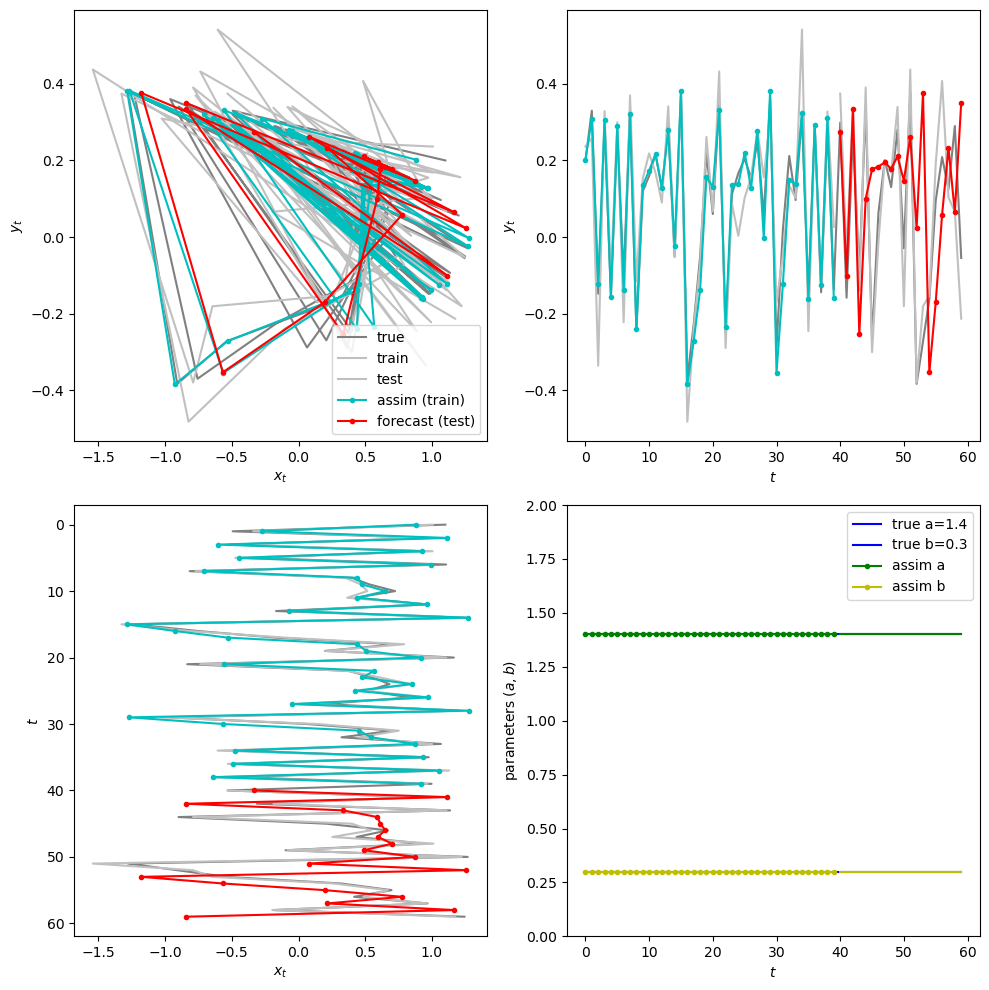

In [13]:
plot_result_trajectory(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('2a_traj_no_para_no_inf.png')
plt.show()

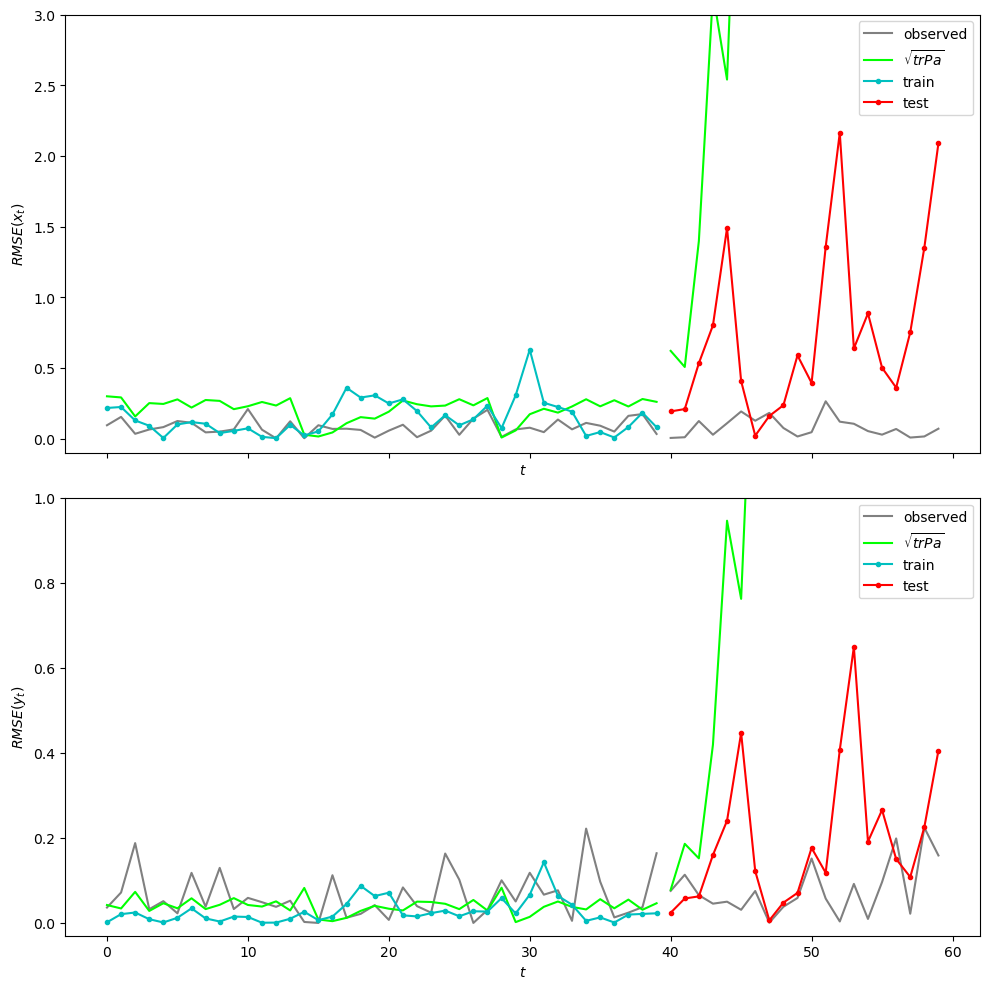

In [14]:
plot_result_rmse(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('2a_rmse_no_para_no_inf.png')
plt.show()

### Additive Inflation

In [15]:
x0, y0 = train_Y[0, :]
Xa0 = np.array([x0, y0, 1.4, 0.3])

P0 = np.eye(4) * 0.1
P0[2, 2] = P0[3, 3] = 0.0
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

a_xy = 0.0001
a_a = a_b = 0.0
P_add = np.array([[a_xy, 0,     0,   0,  ], 
                  [0,     a_xy, 0,   0,  ],
                  [0,     0,    a_a, 0,  ],
                  [0,     0,    0,   a_b,]])


Ho = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0]])

Ro = np.eye(2) * 0.1

for i in range(train_size):
    M = np.zeros((4, 4))
    M[0:2, 0:2] = get_tlm_by_approx(assim_X[-1], "t_dummy", Henon_explicit)[0:2, 0:2] # only for x, y
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], Henon_explicit, M, H=Ho, R=Ro, Pa=assim_Pa[-1] + P_add)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[-1]}")

estim_Pf: [[0.22312398 0.03952338 0.         0.        ]
 [0.03952338 0.00700425 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


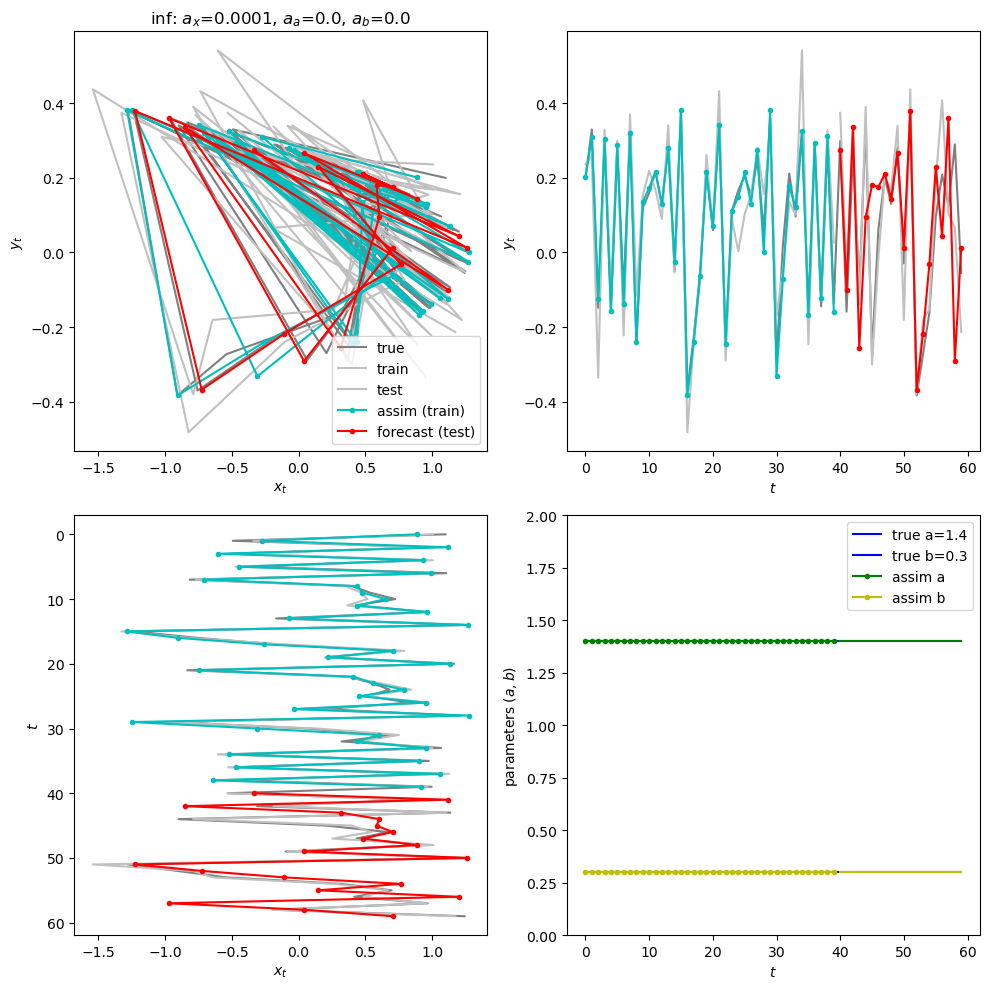

In [16]:
fig, ax = plot_result_trajectory(assim_X, assim_Pa)

ax[0, 0].set_title(f'inf: $a_x$={a_xy}, $a_a$={a_a}, $a_b$={a_b}')

plt.tight_layout()

plt.savefig('2b_traj_no_para_yes_inf.png')
plt.show()

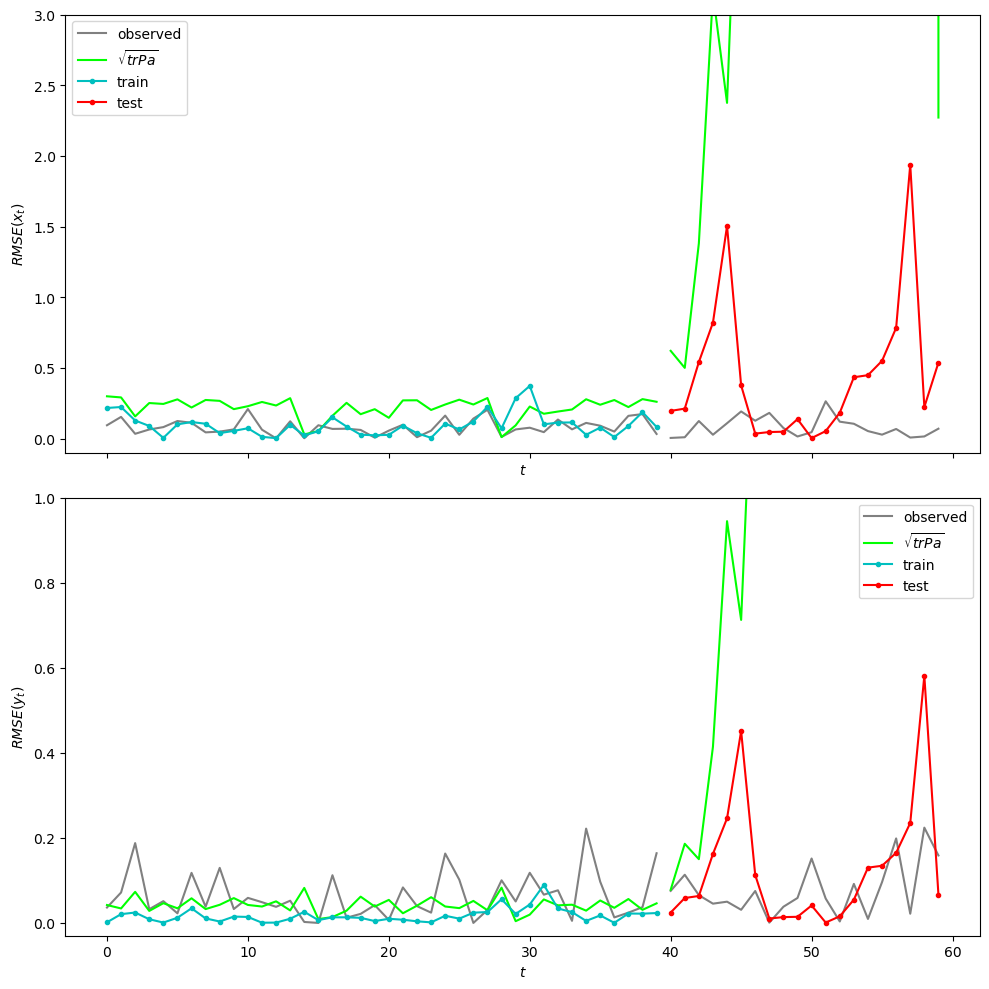

In [17]:
plot_result_rmse(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('2b_rmse_no_para_yes_inf.png')
plt.show()

## パラメータ推定実験 (Simultaneous Estimation)

### No Inflation

In [18]:
x0, y0 = train_Y[0, :]
Xa0 = np.array([x0, y0, 2.0, 0.0])

P0 = np.eye(4) * 0.1
P0[2, 2] = P0[3, 3] = 0.5
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

Ho = np.array([[1, 0, 0, 0], 
               [0, 1, 0, 0]])

Ro = np.eye(2) * 0.1

for i in range(train_size):
    M = get_tlm_by_approx(assim_X[-1], "t_dummy", Henon_explicit) # for x, y, a, b
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], Henon_explicit, M, H=Ho, R=Ro, Pa=assim_Pa[-1])
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[-1]}")

estim_Pf: [[ 0.19349447  0.03193084 -0.00540797  0.00203871]
 [ 0.03193084  0.0058907   0.0006474  -0.00026915]
 [-0.00540797  0.0006474   0.00510321 -0.00143149]
 [ 0.00203871 -0.00026915 -0.00143149  0.00062564]]


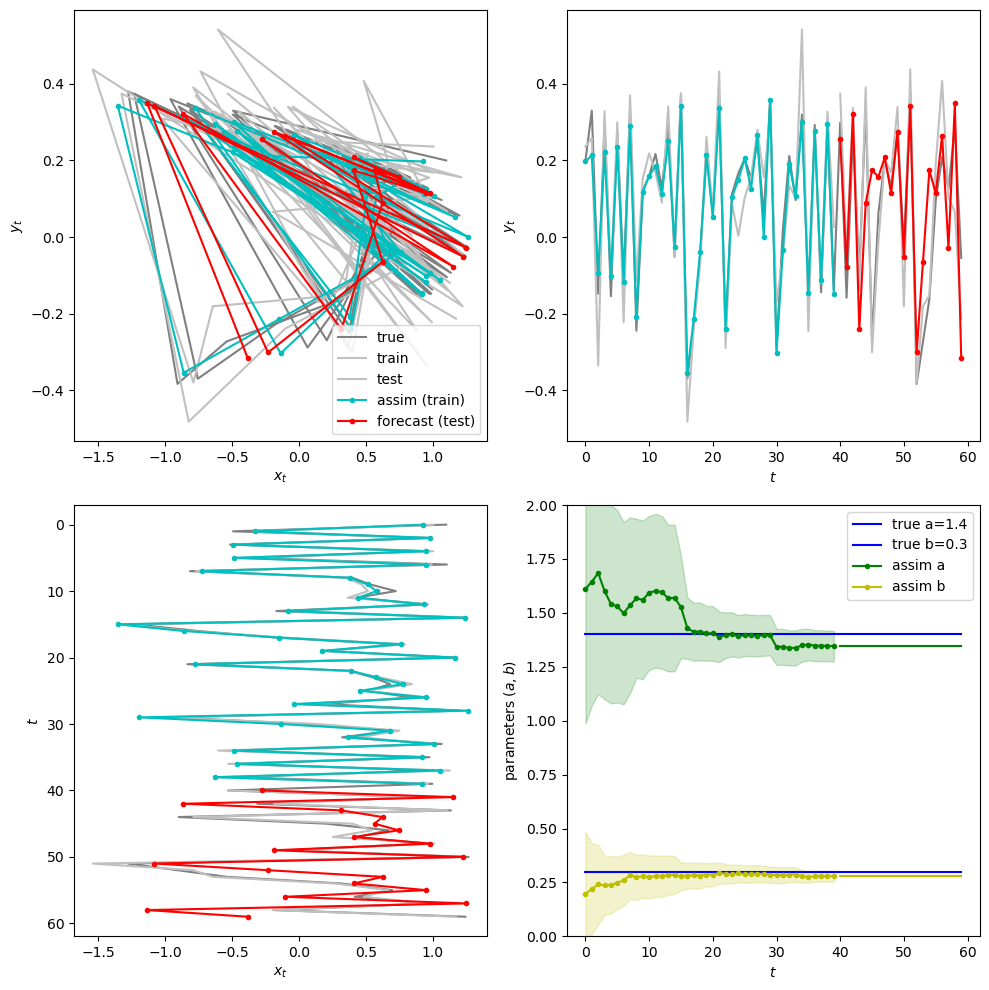

In [19]:
plot_result_trajectory(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('3a_traj_yes_para_no_inf.png')
plt.show()

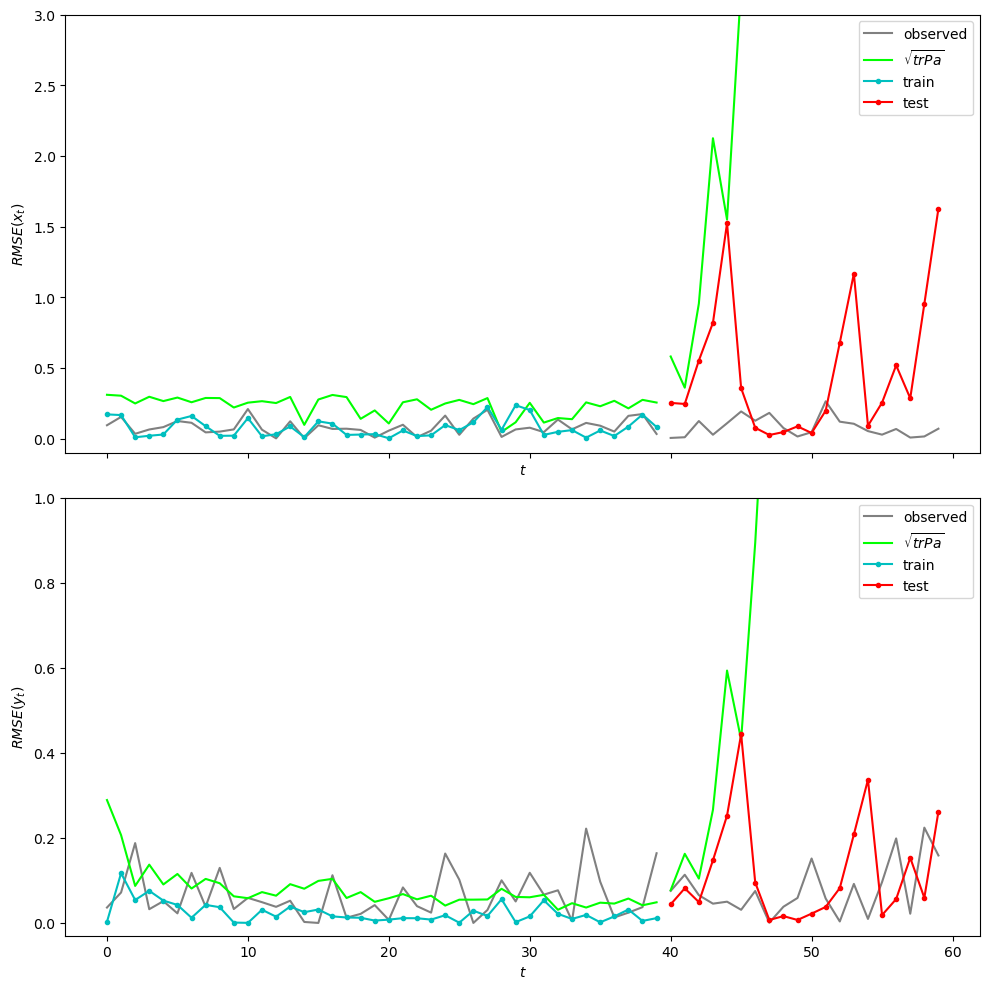

In [20]:
plot_result_rmse(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('3a_rmse_yes_para_no_inf.png')
plt.show()

### Yes Inflation

In [52]:
x0, y0 = train_Y[0, :]
Xa0 = np.array([x0, y0, 2.0, 0.0])

P0 = np.eye(4) * 0.1
P0[2, 2] = P0[3, 3] = 0.5
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

a_xy = 0.001
a_a = 0.05
a_b = 0.03
P_add = np.array([[a_xy, 0,     0,   0,  ], 
                  [0,     a_xy, 0,   0,  ],
                  [0,     0,    a_a, 0,  ],
                  [0,     0,    0,   a_b,]])

Ho = np.array([[1, 0, 0, 0], 
               [0, 1, 0, 0]])

Ro = np.eye(2) * 0.1

for i in range(train_size):
    M = get_tlm_by_approx(assim_X[-1], "t_dummy", Henon_explicit) # for x, y, a, b
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], Henon_explicit, M, H=Ho, R=Ro, Pa=assim_Pa[-1] + P_add)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"estim_Pf: {estim_Pf[-1]}")

estim_Pf: [[ 0.39476391  0.02950764 -0.16924286  0.034834  ]
 [ 0.02950764  0.04155864 -0.01501142 -0.0485985 ]
 [-0.16924286 -0.01501142  0.2530736   0.00966407]
 [ 0.034834   -0.0485985   0.00966407  0.07349437]]


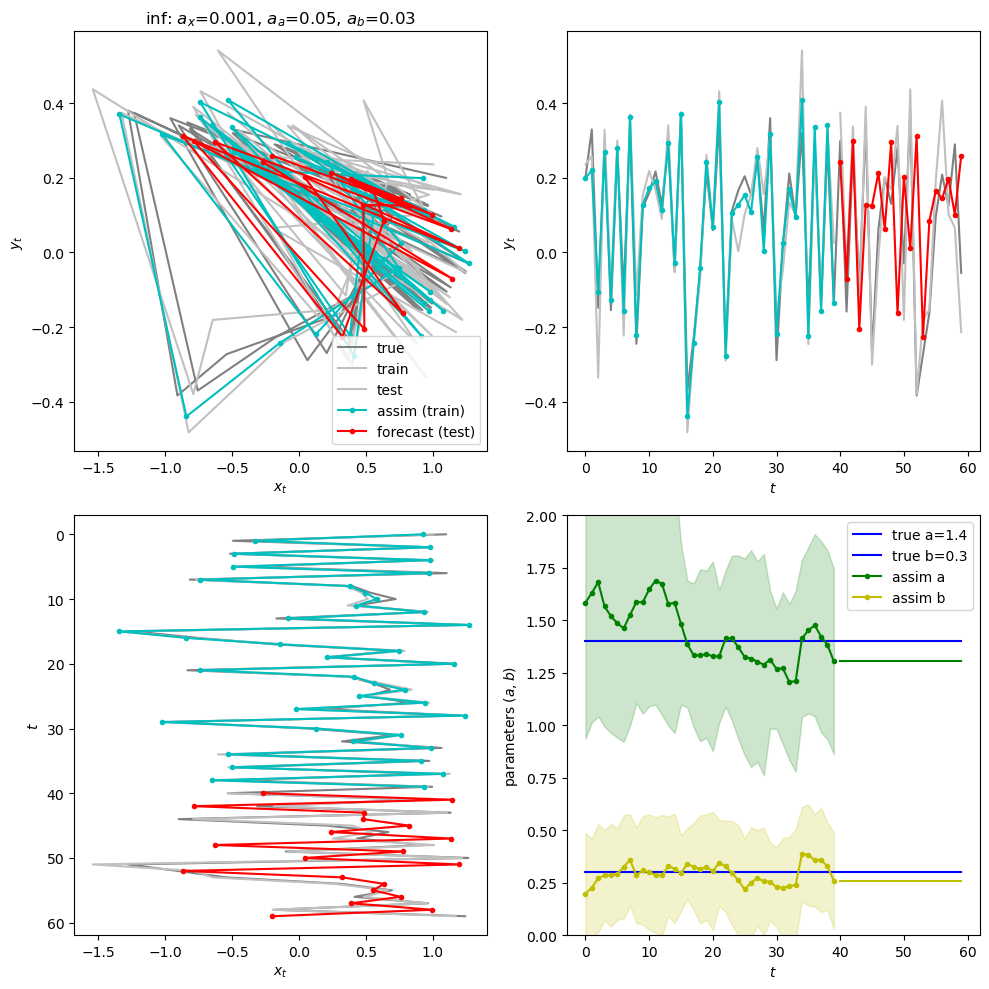

In [53]:
fig, ax = plot_result_trajectory(assim_X, assim_Pa)

ax[0, 0].set_title(f'inf: $a_x$={a_xy}, $a_a$={a_a}, $a_b$={a_b}')

plt.tight_layout()

plt.savefig('3b_traj_yes_para_yes_inf.png')
plt.show()

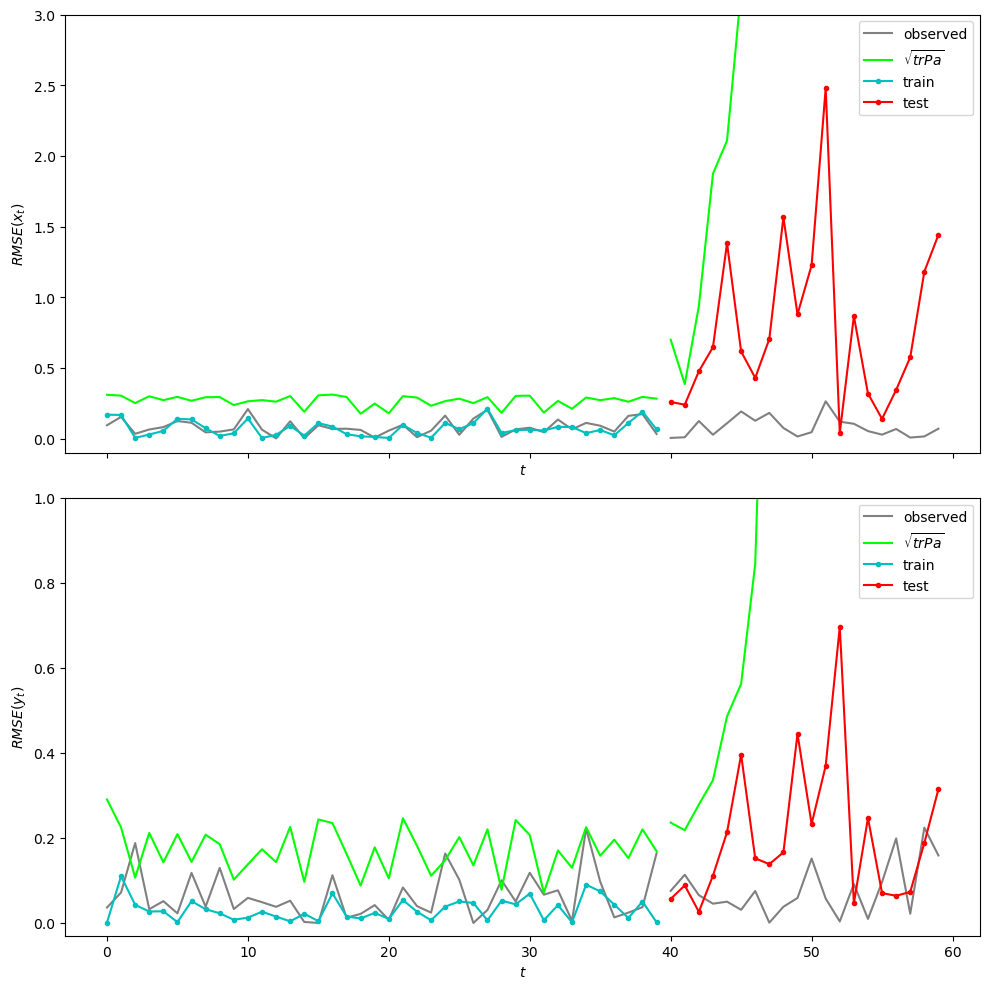

In [54]:
plot_result_rmse(assim_X, assim_Pa)

plt.tight_layout()

plt.savefig('3b_rmse_yes_para_yes_inf.png')

plt.show()

## 機械学習的パラメータ推定

$$
\begin{pmatrix}
\delta x_i \\[10pt] \delta y_i \\[10pt] \delta a \\[10pt] \delta b
\end{pmatrix}

=

\begin{pmatrix}
\frac{\partial x_i}{\partial x_{i-1}} & \frac{\partial x_i}{\partial y_{i-1}} & \frac{\partial x_i}{\partial a} & \frac{\partial x_i}{\partial b} \\[10pt]
\frac{\partial y_i}{\partial x_{i-1}} & \frac{\partial y_i}{\partial y_{i-1}} & \frac{\partial y_i}{\partial a} & \frac{\partial y_i}{\partial b} \\[10pt]
0 & 0 & 1 & 0 \\[10pt]
0 & 0 & 0 & 1 \\[10pt]
\end{pmatrix}

\begin{pmatrix}
\delta x_{i-1} \\[10pt] \delta y_{i-1} \\[10pt] \delta a \\[10pt] \delta b
\end{pmatrix}
$$

In [24]:
def id(x, t="dummy"):
    return x

In [25]:
Xa0 = np.array([2.0, 0.0])

P0 = np.eye(2) * 0.5
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

Ro = np.eye(2) * 0.1

for i in range(train_size):
    x, y = train_Y[i, :]
    a, b = assim_X[-1]
    X0 = np.array([x, y, a, b])
    H = get_tlm_by_approx(X0, "t_dummy", Henon_explicit)[0:2, 2:4] # only for x/a, x/b, \\ y/a, y/b
    
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], id, M=np.eye(2), H=H, R=Ro, Pa=assim_Pa[-1])
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"TLM: {get_tlm_by_approx(X0, 't_dummy', Henon_explicit)}")
print(f"H: {H}")
print(f"estim_Pf: {estim_Pf[-1]}")

TLM: [[ 0.86798561  1.         -0.93033897  0.        ]
 [-0.09057877  0.          0.          0.96454081]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
H: [[-0.93033897  0.        ]
 [ 0.          0.96454081]]
estim_Pf: [[0.00443087 0.        ]
 [0.         0.00430944]]


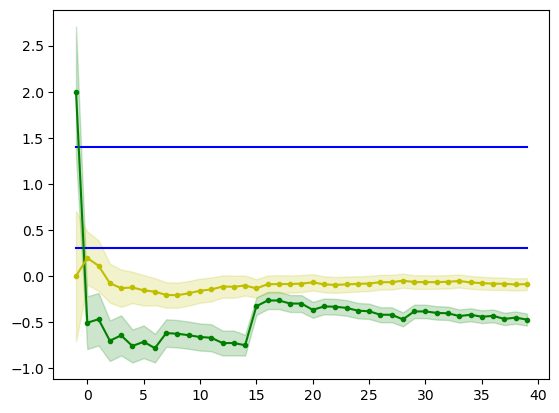

In [26]:
assim_X = np.array(assim_X)
assim_Pa = np.array(assim_Pa)

train_t = np.arange(-1, train_size)

plt.plot(train_t, np.ones(train_size+1)*1.4, 'blue',  label='true a=1.4')
plt.plot(train_t, np.ones(train_size+1)*0.3, 'blue',  label='true b=0.3')

plt.plot(train_t, assim_X[:, 0], 'g.-', label='assim (a)')
plt.fill_between(train_t, assim_X[:, 0] - np.sqrt(assim_Pa[:, 0, 0]), assim_X[:, 0] + np.sqrt(assim_Pa[:, 0, 0]), color='g', alpha=0.2)

plt.plot(train_t, assim_X[:, 1], 'y.-', label='assim (b)')
plt.fill_between(train_t, assim_X[:, 1] - np.sqrt(assim_Pa[:, 1, 1]), assim_X[:, 1] + np.sqrt(assim_Pa[:, 1, 1]), color='y', alpha=0.2)

plt.show()

## Additive Inflation

In [27]:
Xa0 = np.array([2.0, 0.0])

P0 = np.eye(2) * 10
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

a_a = 0
a_b = 10
P_add = np.array([[a_a, 0,  ], 
                  [0,   a_b,]])

Ro = np.eye(2) * 0.1

for i in range(train_size):
    x, y = train_Y[i, :]
    a, b = assim_X[-1]
    X0 = np.array([x, y, a, b])
    H = get_tlm_by_approx(X0, "t_dummy", Henon_explicit)[0:2, 2:4] # only for x/a, x/b, \\ y/a, y/b
    
    Pf, nX, nPa = KalmanFilter(assim_X[-1], "t_dummy", train_Y[i, :], id, M=np.eye(2), H=H, R=Ro, Pa=assim_Pa[-1]+P_add)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"TLM: {get_tlm_by_approx(X0, 't_dummy', Henon_explicit)}")
print(f"H: {H}")
print(f"estim_Pf: {estim_Pf[-1]}")

TLM: [[ 0.90812818  1.         -0.93033897  0.        ]
 [-0.50948955  0.          0.          0.96454081]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
H: [[-0.93033897  0.        ]
 [ 0.          0.96454081]]
estim_Pf: [[4.46848707e-03 0.00000000e+00]
 [0.00000000e+00 1.02450684e+01]]


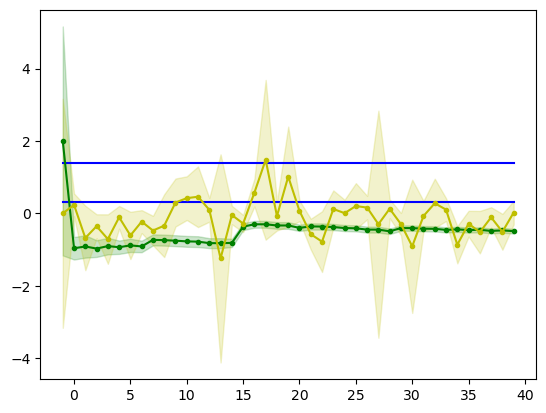

In [28]:
assim_X = np.array(assim_X)
assim_Pa = np.array(assim_Pa)

train_t = np.arange(-1, train_size)

plt.plot(train_t, np.ones(train_size+1)*1.4, 'blue',  label='true a=1.4')
plt.plot(train_t, np.ones(train_size+1)*0.3, 'blue',  label='true b=0.3')

plt.plot(train_t, assim_X[:, 0], 'g.-', label='assim (a)')
plt.fill_between(train_t, assim_X[:, 0] - np.sqrt(assim_Pa[:, 0, 0]), assim_X[:, 0] + np.sqrt(assim_Pa[:, 0, 0]), color='g', alpha=0.2)

plt.plot(train_t, assim_X[:, 1], 'y.-', label='assim (b)')
plt.fill_between(train_t, assim_X[:, 1] - np.sqrt(assim_Pa[:, 1, 1]), assim_X[:, 1] + np.sqrt(assim_Pa[:, 1, 1]), color='y', alpha=0.2)

plt.show()

## H 接線形化してあってるの？

In [29]:
x, y= train_Y[0, :]
a, b = 2.0, 0.0

print(Henon_explicit(np.array([x, y, a, b]), "t_dummy"))
print(Henon(np.array([x, y]), a, b))

H = get_tlm_by_approx(np.array([x, y, a, b]), "t_dummy", Henon_explicit, delta=0.0001)[0:2, 2:4] # only for x/a, x/b, \\ y/a, y/b
print(H @ np.array([a, b]))

[-0.78860235  0.          2.          0.        ]
[-0.78860235  0.        ]
[-2.02485245  0.        ]


あってなさそう。Kalman Filter の X を修正する項を変更してみよう。

In [30]:
def KalmanFilter_H(X: np.ndarray, y: np.ndarray, y_pre, H, R, Pa, Q=0):
    # forecast
    # X = Model(X, t)       # not used Xf = Xa_pre
    # Pf = M @ Pa @ M.T + Q # not used Pf = Pa_pre
    Pf = Pa

    # update
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    # nX = X + K @ (y - H @ X)
    nX = X + K @ (y - Henon(y_pre, X[0], X[1]))
    nPa = (np.eye(X.shape[0]) - K @ H) @ Pf

    return Pf, nX, nPa, K

In [60]:
Xa0 = np.array([2.0, 0.0])

P0 = np.eye(2) * 0.5
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]

Ro = np.eye(2) * 0.1

for i in range(1, train_size):
    x, y = train_Y[i-1, :]
    a, b = assim_X[-1]
    X0 = np.array([x, y, a, b])
    H = get_tlm_by_approx(X0, "t_dummy", Henon_explicit)[0:2, 2:4] # only for x/a, x/b, \\ y/a, y/b
    
    Pf, nX, nPa, K = KalmanFilter_H(assim_X[-1], train_Y[i, :], train_Y[i-1, :], H=H, R=Ro, Pa=assim_Pa[-1])
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)

print(f"TLM: {get_tlm_by_approx(X0, 't_dummy', Henon_explicit)}")
print(f"H: {H}")
print(f"estim_Pf: {estim_Pf[-1]}")

TLM: [[ 1.72075676  1.         -0.39812651  0.        ]
 [ 0.30524784  0.          0.         -0.63097267]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
H: [[-0.39812651  0.        ]
 [ 0.         -0.63097267]]
estim_Pf: [[0.00446221 0.        ]
 [0.         0.00438466]]


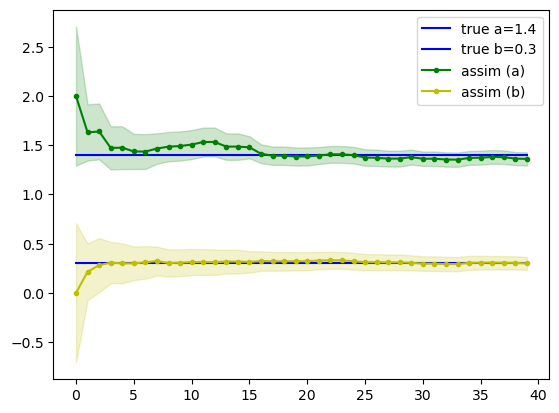

In [61]:
assim_X = np.array(assim_X)
assim_Pa = np.array(assim_Pa)

train_t = np.arange(train_size)

plt.plot(train_t, np.ones(train_size)*1.4, 'blue',  label='true a=1.4')
plt.plot(train_t, np.ones(train_size)*0.3, 'blue',  label='true b=0.3')

plt.plot(train_t, assim_X[:, 0], 'g.-', label='assim (a)')
plt.fill_between(train_t, assim_X[:, 0] - np.sqrt(assim_Pa[:, 0, 0]), assim_X[:, 0] + np.sqrt(assim_Pa[:, 0, 0]), color='g', alpha=0.2)

plt.plot(train_t, assim_X[:, 1], 'y.-', label='assim (b)')
plt.fill_between(train_t, assim_X[:, 1] - np.sqrt(assim_Pa[:, 1, 1]), assim_X[:, 1] + np.sqrt(assim_Pa[:, 1, 1]), color='y', alpha=0.2)

plt.legend()

plt.savefig('4a_para_no_inf.png')
plt.show()

なんかいい感じ〜〜

## Additive Inflation

In [58]:
Xa0 = np.array([2.0, 0.0])

P0 = np.eye(2) * 0.5
assim_X = [Xa0]
assim_Pa = [P0.copy()]
estim_Pf = [P0.copy()]
K_gain = []

a_a = 0.01
a_b = 0.01
P_add = np.array([[a_a, 0,  ], 
                  [0,   a_b,]])

Ro = np.eye(2) * 0.1

for i in range(1, train_size):
    x, y = train_Y[i-1, :]
    a, b = assim_X[-1]
    X0 = np.array([x, y, a, b])
    H = get_tlm_by_approx(X0, "t_dummy", Henon_explicit)[0:2, 2:4] # only for x/a, x/b, \\ y/a, y/b
    
    Pf, nX, nPa, K = KalmanFilter_H(assim_X[-1], train_Y[i, :], train_Y[i-1, :], H=H, R=Ro, Pa=assim_Pa[-1]+P_add)
    estim_Pf.append(Pf)
    assim_X.append(nX)
    assim_Pa.append(nPa)
    K_gain.append(K)

print(f"TLM: {get_tlm_by_approx(X0, 't_dummy', Henon_explicit)}")
print(f"H: {H}")
print(f"estim_Pf: {estim_Pf[-1]}")

TLM: [[ 1.6616084   1.         -0.39812651  0.        ]
 [ 0.30988582  0.          0.         -0.63097267]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
H: [[-0.39812651  0.        ]
 [ 0.         -0.63097267]]
estim_Pf: [[0.04004762 0.        ]
 [0.         0.04055763]]


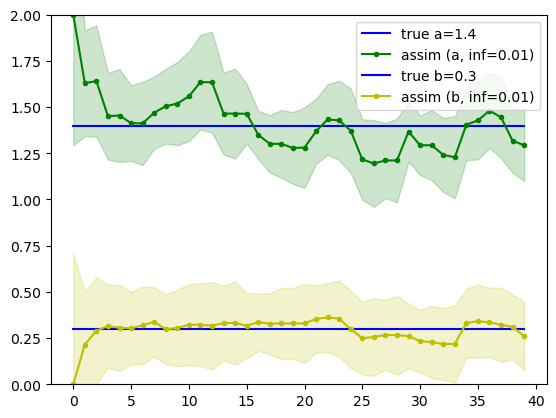

In [59]:
assim_X = np.array(assim_X)
assim_Pa = np.array(assim_Pa)

train_t = np.arange(train_size)

plt.plot(train_t, np.ones(train_size)*1.4, 'blue',  label='true a=1.4')
plt.plot(train_t, assim_X[:, 0], 'g.-', label=f'assim (a, inf={a_a})')
plt.fill_between(train_t, assim_X[:, 0] - np.sqrt(assim_Pa[:, 0, 0]), assim_X[:, 0] + np.sqrt(assim_Pa[:, 0, 0]), color='g', alpha=0.2)

plt.plot(train_t, np.ones(train_size)*0.3, 'blue',  label='true b=0.3')
plt.plot(train_t, assim_X[:, 1], 'y.-', label=f'assim (b, inf={a_b})')
plt.fill_between(train_t, assim_X[:, 1] - np.sqrt(assim_Pa[:, 1, 1]), assim_X[:, 1] + np.sqrt(assim_Pa[:, 1, 1]), color='y', alpha=0.2)

plt.ylim(0, 2)

plt.legend()

plt.savefig('4b_para_yes_inf.png')
plt.show()

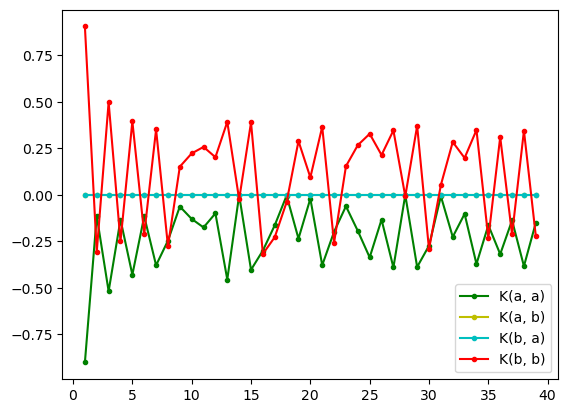

In [36]:
K_gain = np.array(K_gain)

plt.plot(train_t[1:], K_gain[:, 0, 0], 'g.-', label='K(a, a)')
plt.plot(train_t[1:], K_gain[:, 0, 1], 'y.-', label='K(a, b)')
plt.plot(train_t[1:], K_gain[:, 1, 0], 'c.-', label='K(b, a)')
plt.plot(train_t[1:], K_gain[:, 1, 1], 'r.-', label='K(b, b)')

plt.legend(loc='lower right')

plt.savefig('4b_K_gain.png')
plt.show()